<p><font size="6"><b> Raster - vector tools</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2020*
>
> *© 2020, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In the previous notebooks, we mostly worked with either vector data or raster data. 
But, often you will encounter both types of data and will have to combine them.
In this notebook, we show *some* examples of raster/vector interactions.

In [1]:
import pandas as pd
import numpy as np
import geopandas
import rasterio

import xarray as xr

import matplotlib.pyplot as plt

# `rioxarray`: xarray extension based on rasterio

In the previous notebooks, we already used `rasterio` (https://rasterio.readthedocs.io/en/latest/) to read raster files such as GeoTIFFs (through the `xarray.open_rasterio()` function). Rasterio provides support for reading and writing geospatial raster data as numpy N-D arrays, mainly through bindings to the GDAL library. 

In addition, rasterio provides a Python API to perform some GIS raster operations (clip, mask, warp, merge, transformation,...) and can be used to only load a subset of a large dataset into memory. However, the main complexity in using `rasterio`, is that the spatial information is decoupled from the data itself (i.e. the numpy array). This means that you need to keep track and organize the extent and metadata throughout the operations (e.g. the "transform") and you need to keep track of what each dimension represents (y-first, as arrays are organized along rows first). Notebook [12-rasterio.ipynb](12-rasterio.ipynb) goes into more depth on the rasterio package itself. 



Enter `rioxarray` (https://corteva.github.io/rioxarray/stable/index.html), which extends xarray with geospatial functionality powered by rasterio. 

In [2]:
import rioxarray

In [3]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [4]:
data = rioxarray.open_rasterio(data_file)
data

<xarray.DataArray (band: 3, y: 227, x: 447)>
[304407 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.935e+05 5.935e+05 ... 6.113e+05 6.114e+05
  * y            (y) float64 6.578e+06 6.577e+06 ... 6.569e+06 6.568e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

The `rioxarray.open_rasterio` function is similar to `xarray.open_rasterio`, but in addition adds a `spatial_ref` coordinate to keep track of the spatial reference information.

Once `rioxarray` is imported, it also provides a `.rio` accessor on the xarray.DataArray object, which gives access to some properties of the raster data:

In [5]:
data.rio.crs

CRS.from_epsg(3857)

In [6]:
data.rio.bounds()

(593476.1968631798, 6568444.042372982, 611391.1253675179, 6577549.60336745)

In [7]:
data.rio.nodata

## Extract the data you need

In many applications, a specific research area is used. Extracting the data you need from a given raster data set by a vector (polygon) file is a common operation in GIS analysis. We use the clipping example to explain the typical workflow with rioxarray / rasterio.

For our Herstappe example, the study area is available as vector data `./data/herstappe/vector/herstappe.geojson`:

In [8]:
herstappe_vect = geopandas.read_file("./data/herstappe/vector/herstappe.geojson")
herstappe_vect

,gml_id,UIDN,OIDN,TERRID,NISCODE,NAAM,DATPUBLBS,NUMAC,geometry
0,Refgem.202,642.0,37.0,59.0,73028,Herstappe,1831-02-07,,"MULTIPOLYGON (((5.41544 50.72148, 5.41568 50.7..."


<AxesSubplot:>

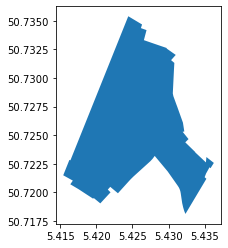

In [9]:
herstappe_vect.plot()

In [10]:
herstappe_vect.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Make sure both data sets are defined in the same CRS and extracting the geometry can be used as input for the masking:

In [11]:
herstappe_vect = herstappe_vect.to_crs(epsg=3857)

In [12]:
clipped = data.rio.clip(herstappe_vect.geometry)

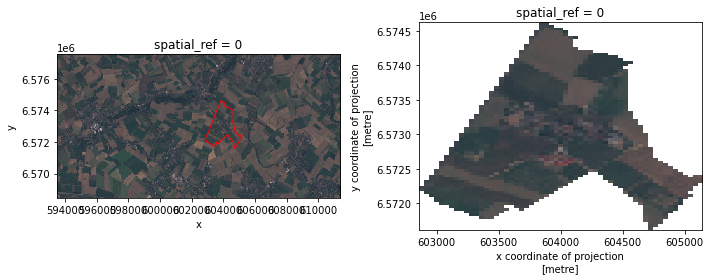

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
data.plot.imshow(ax=ax1)
herstappe_vect.plot(ax=ax1, facecolor="none", edgecolor="red")
clipped.plot.imshow(ax=ax2)
fig.tight_layout()

The above uses the `rasterio` package (with the `mask` and `geometry_mask` / `rasterize` functionality) under the hood. This simplifies the operation compared to directly using `rasterio`.


```python
# cfr. The Rasterio workflow

from rasterio.mask import mask

# 1 - Open a data set using the context manager
with rasterio.open(data_file) as src: 

    # 2 - Read and transform the data set by clipping
    out_image, out_transform = mask(src, herstappe_vect.geometry, crop=True)
    
    # 3 - Update the spatial metadata/profile of the data set
    herstappe_profile = src.profile
    herstappe_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})
    # 4 - Save the new data set with the updated metadata/profile                   
    with rasterio.open("./herstappe_masked.tiff", "w", **herstappe_profile) as dest: 
        dest.write(out_image)
```

The [12-rasterio.ipynb](12-rasterio.ipynb) notebook explains this workflow in more detail.

One important difference, though, is that the above `rasterio` workflow will not load the full raster into memory when only loading (clipping) a small part of it. This can also be achieved in `rioxarray` with the `from_disk` keyword.

## Convert vector to raster

### Load DEM raster and river vector data

As example, we are using data from the Zwalm river area in Flanders. 

The digital elevation model (DEM) can be downloaded via the [governmental website](https://download.vlaanderen.be/Producten/Detail?id=936&title=Digitaal_Hoogtemodel_Vlaanderen_II_DSM_raster_5_m) ([download link](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-5m/DHMVIIDSMRAS5m_k30.zip), extracted in the `/data` directory for this example)/ 

In [14]:
dem_zwalm_file = "data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif"

In [15]:
dem_zwalm = xr.open_rasterio(dem_zwalm_file).sel(band=1)

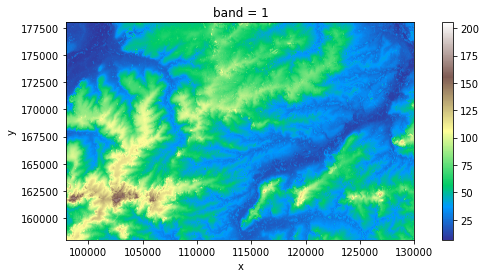

In [16]:
img = dem_zwalm.plot.imshow(
    cmap="terrain", figsize=(10, 4), interpolation='antialiased')
img.axes.set_aspect("equal")

Next, we download the shapes of the rivers in the area through a WFS (Web Feature Service):

In [17]:
import json
import requests

wfs_rivers = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VHAWaterlopen:Wlas', outputFormat='json',
              cql_filter="(VHAZONENR=460)OR(VHAZONENR=461)", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_rivers, params=params)

And convert this to a GeoDataFrame:

In [18]:
# Create GeoDataFrame from geojson
segments = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [19]:
segments.head()

,geometry,UIDN,OIDN,VHAS,VHAG,NAAM,REGCODE,REGCODE1,BEHEER,CATC,LBLCATC,BEKNR,BEKNAAM,STRMGEB,KWALDOEL,LBLKWAL,GEO,LBLGEO,VHAZONENR,WTRLICHC
0,"LINESTRING (104155.250 174948.957, 104147.271 ...",356290,65768,6020608,5001,Zwalmbeek,OS266a,,V0104,1,"Geklasseerd, eerste categorie",6,Boven-Scheldebekken,Schelde,110,Produktie drinkwater,2,< 0.25 m,461,VL11_63
1,"LINESTRING (101574.265 175606.789, 101569.762 ...",358955,65539,6020496,5000,Zwalmbeek,OS266,,V0104,1,"Geklasseerd, eerste categorie",6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63
2,"LINESTRING (100870.618 175566.637, 100868.874 ...",358962,65737,6020577,5000,Zwalmbeek,OS266,,V0104,1,"Geklasseerd, eerste categorie",6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63
3,"LINESTRING (106457.412 174082.427, 106455.008 ...",358966,65777,6020617,5000,Zwalmbeek,OS266,,V0104,1,"Geklasseerd, eerste categorie",6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63
4,"LINESTRING (105267.452 174665.979, 105262.210 ...",376442,65542,6020499,5000,Zwalmbeek,OS266,,V0104,1,"Geklasseerd, eerste categorie",6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63


<AxesSubplot:>

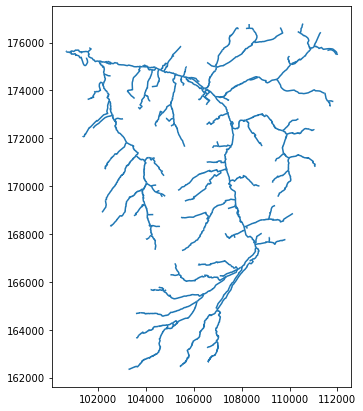

In [20]:
segments.plot(figsize=(8, 7))

### Clip raster with vector

The catchment extent is much smaller than the DEM file, so clipping the data first will make the computation less heavy. 

Let's first download the catchment area of the Zwalm river from the Flemish government:

In [21]:
import json
import requests

wfs_bekkens = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/Watersystemen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='Watersystemen:WsDeelbek', outputFormat='json',
              cql_filter="DEELBEKNM='Zwalm'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_bekkens, params=params)
catchment = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [22]:
catchment

,geometry,OIDN,UIDN,DEELBID,DEELBEKNM
0,"MULTIPOLYGON (((112222.397 176907.296, 112178....",165,264,06-05,Zwalm


Save to a file for later reuse:

In [23]:
# save to file
catchment = catchment.to_crs('epsg:4326') # geojson is default 4326
catchment.to_file("./data/zwalmbekken.geojson", driver="GeoJSON")

<AxesSubplot:>

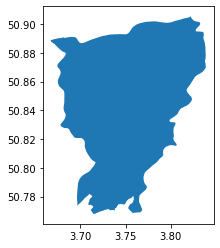

In [24]:
geopandas.read_file("./data/zwalmbekken.geojson").plot()

#### 1. Using rioxarray (rasterio)

As shown above, we can use rioxarray to clip the raster file:

In [25]:
dem_zwalm = xr.open_rasterio(dem_zwalm_file).sel(band=1)
dem_zwalm

<xarray.DataArray (y: 4000, x: 6400)>
[25600000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 1.78e+05 1.78e+05 1.78e+05 ... 1.58e+05 1.58e+05
  * x        (x) float64 9.8e+04 9.801e+04 9.801e+04 ... 1.3e+05 1.3e+05 1.3e+05
Attributes:
    transform:      (5.0, 0.0, 98000.0, 0.0, -5.0, 178000.0)
    crs:            +init=epsg:31370
    res:            (5.0, 5.0)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    VERTICAL_SRS:   EPSG:5110

In [26]:
clipped = dem_zwalm.rio.clip(catchment.to_crs('epsg:31370').geometry)

Using rioxarray's `to_raster()` method, we can also save the result to a new GeoTIFF file:

In [27]:
clipped.rio.to_raster("./dem_masked_rio.tiff")

This DEM raster file used -9999 as the NODATA value, and this is therefore also used for the clipped result:

In [28]:
clipped.rio.nodata

-9999.0

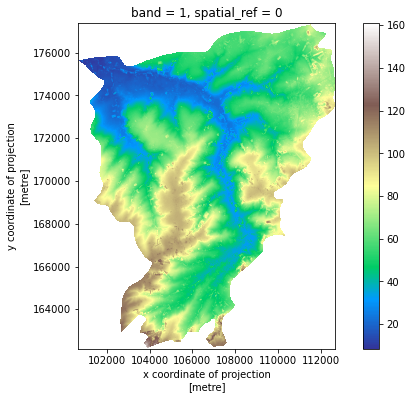

In [29]:
img = clipped.where(clipped != -9999).plot.imshow(
    cmap='terrain', figsize=(10, 6), interpolation='antialiased')
img.axes.set_aspect("equal")

With rioxarray, we can also convert nodata values to NaNs (and thus using float dtype) when loading the raster data:

In [30]:
dem_zwalm2 = rioxarray.open_rasterio(dem_zwalm_file, masked=True).sel(band=1)

In [31]:
dem_zwalm2.rio.nodata

nan

In [32]:
dem_zwalm2.rio.clip(catchment.to_crs('epsg:31370').geometry)

<xarray.DataArray (y: 3050, x: 2405)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 1.774e+05 1.774e+05 ... 1.621e+05 1.621e+05
  * x            (x) float64 1.007e+05 1.007e+05 ... 1.127e+05 1.127e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

If we want to avoid loading the full original raster data, the `from_disk` keyword can be used.

In [33]:
dem_zwalm2.rio.clip(catchment.to_crs('epsg:31370').geometry, from_disk=True)

<xarray.DataArray (y: 3050, x: 2405)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 1.774e+05 1.774e+05 ... 1.621e+05 1.621e+05
  * x            (x) float64 1.007e+05 1.007e+05 ... 1.127e+05 1.127e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

#### 2. Using GDAL CLI

If we have the raster and vector files on disk, [`gdal CLI`](https://gdal.org/programs/index.html) will be very fast to work with (note that GDAL automatically handles the CRS difference of the raster and vector). 

In [36]:
rm ./dem_masked_gdal.tiff

In [37]:
!gdalwarp -cutline ./data/zwalmbekken.geojson -crop_to_cutline data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif ./dem_masked_gdal.tiff

Creating output file that is 2403P x 3049L.
Processing data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif.
Copying nodata values from source data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif to destination ./dem_masked_gdal.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.


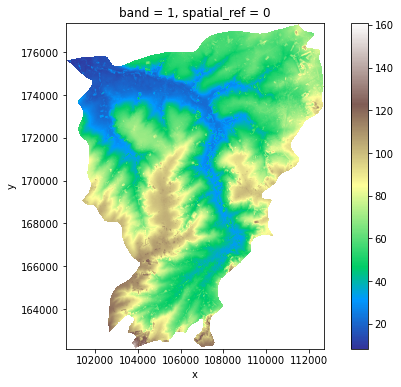

In [38]:
clipped_gdal = rioxarray.open_rasterio("./dem_masked_gdal.tiff", masked=True).sel(band=1)
img = clipped_gdal.plot.imshow(
    cmap="terrain", figsize=(10, 6), interpolation='antialiased')
img.axes.set_aspect("equal")

### Convert vector to raster

To create a raster with the vector "burned in", we can use the `rasterio.features.rasterize` function. This expects a list of (shape, value) tuples, and an output image shape and transform. Here, we will create a new raster image with the same shape and extent as the DEM above. And we first take a buffer of the river lines:

In [39]:
import rasterio.features

In [40]:
segments_buffered = segments.geometry.buffer(100)
img = rasterio.features.rasterize(
    segments_buffered, 
    out_shape=clipped.shape, 
    transform=clipped.rio.transform())

In [41]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

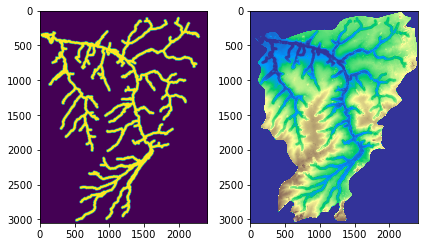

In [42]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(img*50)
ll = ax1.imshow(clipped.values - img*20, vmin=0, cmap="terrain") # just as an example
plt.tight_layout()

## Extracting values from rasters based on vector data

The **rasterstats** package provides methods to calculate summary statistics of geospatial raster datasets based on vector geometries (https://github.com/perrygeo/python-rasterstats)

To illustrate this, we are reading a raster file with elevation data of the full world (the file contains a single band for the elevation, save the file in the `data` subdirectory; [download link](https://www.eea.europa.eu/data-and-maps/data/world-digital-elevation-model-etopo5/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/at_download/file)):

In [43]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")

In [44]:
dem_geotiff = "data/raw/DEM_geotiff/alwdgg.tif"

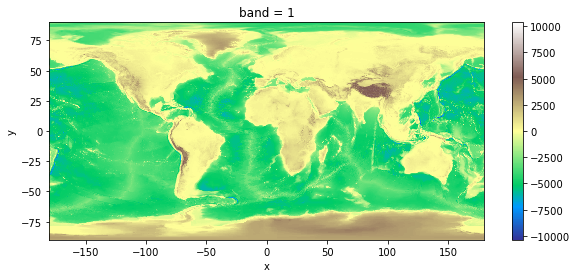

In [45]:
img = xr.open_rasterio(dem_geotiff).sel(band=1).plot.imshow(cmap="terrain", figsize=(10, 4), )
img.axes.set_aspect("equal")

Given this raster of the elevation, we might want to know the elevation at a certain location or for each country.
For the countries example, we want to extract the pixel values that fall within a country polygon, and calculate a statistic for it, such as the mean or the maximum.

Such functionality to extract information from a raster for given vector data is provided by the rasterstats package.

In [46]:
import rasterstats

For extracting the pixel values for polygons, we use the `zonal_stats` function, passing it the GeoSeries, the path to the raster file, and the method to compute the statistics.

In [47]:
result = rasterstats.zonal_stats(countries.geometry, dem_geotiff,
                                 stats=['min', 'mean', 'max'])

/home/joris/miniconda3/envs/DS-geospatial/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


The results can be assigned to new columns:

In [48]:
countries[['min', 'max', 'mean']] = pd.DataFrame(result)

In [49]:
countries.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",244.0,5699.0,1865.941620
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...",-1002.0,2103.0,1070.461868
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",-250.0,2138.0,731.139738
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",-44.0,1524.0,115.114370
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...",-945.0,5181.0,655.130176


And then we can sort by the average elevation of the country:

In [50]:
countries.sort_values('mean', ascending=False).head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
157,TJK,Tajikistan,Asia,8468555.0,25810.0,"POLYGON ((74.980 37.420, 73.949 37.422, 73.260...",335.0,6096.0,3103.231105
85,KGZ,Kyrgyzstan,Asia,5789122.0,21010.0,"POLYGON ((80.260 42.350, 80.119 42.124, 78.544...",610.0,5791.0,2867.717142
24,BTN,Bhutan,Asia,758288.0,6432.0,"POLYGON ((91.697 27.772, 92.104 27.453, 92.033...",305.0,5486.0,2573.559846
119,NPL,Nepal,Asia,29384297.0,71520.0,"POLYGON ((81.111 30.183, 81.526 30.423, 82.328...",61.0,6705.0,2408.907816
6,ATA,Antarctica,Antarctica,4050.0,810.0,"MULTIPOLYGON (((-59.572 -80.040, -59.866 -80.5...",-1970.0,4115.0,2374.075028


For points, a similar function called `point_query` can be used (specifying the interpolation method):

In [51]:
cities["elevation"] = rasterstats.point_query(cities.geometry, 
                                              dem_geotiff, interpolate='bilinear')

/home/joris/miniconda3/envs/DS-geospatial/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [52]:
cities.sort_values(by="elevation", ascending=False).head()

,name,geometry,elevation
122,La Paz,POINT (-68.15193 -16.49603),4378.784708
126,Thimphu,POINT (89.63901 27.47299),3554.551761
114,Sucre,POINT (-65.25952 -19.04097),3116.501683
88,Quito,POINT (-78.50200 -0.21304),2748.044039
211,Kabul,POINT (69.18131 34.51864),2588.508886


-----------

### A bit more about WFS

> The Web Feature Service (WFS) represents a change in the way geographic information is created, modified and exchanged on the Internet. Rather than sharing geographic information at the file level using File Transfer Protocol (FTP), for example, the WFS offers direct fine-grained...

(https://www.ogc.org/standards/wfs)

In brief, the WFS is the specification to __access and download vector datasets__.

To access WFS data, you need the following information:
- URL of the service, e.g. `https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs`. Looking for these URLS, check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en)
- The available projections and layers, also check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en) or start looking into the `GetCapabilities`, e.g. [vha waterlopen](https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs?REQUEST=GetCapabilities&SERVICE=WFS)

Instead of downloading the entire data set, filtering the request itself (only downloading what you need) is a good idea, using the `cql_filter` filter. Finding out these is sometimes a bit of hazzle... E.g. quickly [preview the data in QGIS](https://docs.qgis.org/3.10/en/docs/training_manual/online_resources/wfs.html?highlight=wfs).

You can also use the [`OWSLib` library](https://geopython.github.io/OWSLib/#wfs). But as WFS is a webservice, the `requests` package will be sufficient for simple queries. 

As an example - municipalities in Belgium, see https://wfs.michelstuyts.be/service.php?id=140&lang=en, _WFS Voorlopig referentiebestand gemeentegrenzen 2019_

- URL of the service: https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs
- Available projections:  EPSG:4258, EPSG:3812,...
- Available layers: VRBG2019:Refgem:,  VRBG2019:Refarr:,...
- Column `Naam` contains the municipatility, e.g. `Gent`

<AxesSubplot:>

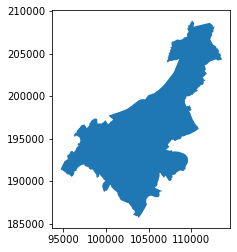

In [53]:
wfs_municipality = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VRBG2019:Refgem', outputFormat='json',
              cql_filter="NAAM='Gent'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_municipality, params=params)
gent = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")
gent.plot()